In [1]:
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn import tree
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, recall_score, precision_score, confusion_matrix 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

Read in credit card data.
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
Due to confidentiality issues, it contains only numerical input variables which are the result of a PCA transformation. These are features V1~V28. In addition, time and amount are provided. Feature 'Class' is our response variable of interest, it takes value in 1 if the transactionw as fraudulent, and 0 otherwise. This is an extremely unbalanced dataset, out of 284, 807 total entries, there are only 492 fraudulent cases, giving us a baseline accuracy of 99.82%, which means if we just guess every transaction is not fraudulent, we expect to be correct 99.82% of the time. The major problem that arises here is that false-negatives (predicting a transaction is legitimate when in fact it is fraudulent) are extremely costly.

To deal with these issues, we use a naive undersampling method to create a subset that has equal fraud and non-fraud cases. We will evaluate our classification model not directly with accuracy, but with area under curve, precision, and recall metrics.

In [2]:
credit_card = pd.read_csv('creditcard.csv')

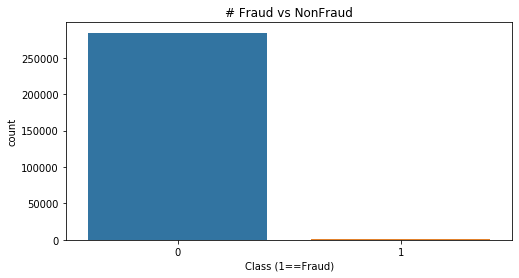

In [3]:
f, ax = plt.subplots(figsize=(8, 4))
sns.countplot(x='Class', data=credit_card)
_ = plt.title('# Fraud vs NonFraud')
_ = plt.xlabel('Class (1==Fraud)')

In [4]:
base_line_accuracy = 1-np.sum(credit_card.Class)/credit_card.shape[0]
base_line_accuracy

0.9982725143693799

Some basic feature engineering: scaling the time and amount columns

In [5]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
credit_card['scaled_amount'] = rob_scaler.fit_transform(credit_card['Amount'].values.reshape(-1,1))
credit_card['scaled_time'] = rob_scaler.fit_transform(credit_card['Time'].values.reshape(-1,1))
credit_card.drop(['Time','Amount'], axis=1, inplace=True)

Since this dataset is highly imbalanced, we apply an undersampling technique so that out dataset has a higher proportion of fraudulent cases.

In [6]:
# shuffle the data before sampling
df = credit_card.sample(frac=1)

# amount of fraud classes 492 rows.
fraud= df.loc[df['Class'] == 1]
multiplier = 9
non_fraud= df.loc[df['Class'] == 0][:len(fraud)*multiplier]

balanced_df = pd.concat([fraud, non_fraud])

# Shuffle dataframe rows
balanced_credit_card = balanced_df.sample(frac=1, random_state=42)

balanced_credit_card.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
240222,1.852889,1.069593,-1.776101,4.617410,0.770413,-0.400859,-0.040970,0.089510,-0.217705,-0.373927,...,-0.176244,0.027437,-0.468006,0.058063,0.148263,0.042278,0.040573,1,-0.293440,0.773059
180501,0.145267,0.453747,1.791921,1.028151,-0.410618,0.840608,-0.588681,0.275899,0.331268,-0.090112,...,0.982964,-0.109857,0.714032,-1.108509,0.840459,0.081307,-0.002894,0,-0.277370,0.468438
160342,2.094938,0.001441,-1.596736,0.209687,0.363921,-0.948205,0.323954,-0.417071,0.507157,-0.016655,...,0.813998,-0.109202,-0.592171,0.385304,-0.072347,-0.017434,-0.061170,0,-0.080067,0.335718
236299,-0.307369,0.687747,0.387342,-0.582081,0.451922,-0.867432,0.568838,0.049035,-0.098913,-0.836060,...,0.197540,-0.045587,0.010578,-0.321087,0.494873,0.254575,0.125427,0,0.013834,0.752617
105918,0.855069,-0.439828,1.247989,1.720902,-0.787988,0.845241,-0.477368,0.361960,0.881259,-0.305195,...,-0.567391,0.013393,0.239000,0.355589,-0.550374,0.075187,0.036855,0,1.053727,-0.175578
93580,1.281973,-0.710610,1.285237,-0.482514,-1.488391,-0.221473,-1.104451,0.064987,-0.311289,0.421542,...,0.758938,0.045721,0.454258,0.247721,-0.195929,0.071352,0.030778,0,-0.103403,-0.237280
95785,-0.257853,2.366063,-2.508196,1.514803,0.662218,-1.528422,0.458841,0.340204,0.119213,-0.519516,...,-0.161684,0.230142,-0.298409,-0.363757,-0.352880,0.462064,0.132834,0,-0.289387,-0.225896
17134,-0.375519,1.354001,-1.823592,-0.849204,2.712523,2.781156,0.034795,1.226209,-0.766675,-1.006564,...,-0.457576,-0.096953,0.877879,0.015175,0.295318,0.144733,0.057231,0,-0.296793,-0.660499
238099,1.971029,0.101474,-1.803507,0.535114,0.240016,-1.407008,0.385872,-0.439940,0.488870,-0.515656,...,0.745347,-0.091432,-0.152259,0.278290,-0.102030,-0.007457,-0.022344,0,0.443653,0.761628
59811,-1.294454,0.347232,2.055542,1.484312,-0.655011,0.063810,-0.599267,0.708412,0.178913,-0.494479,...,0.539801,0.499947,0.380243,-0.406465,-0.315323,0.047878,0.040574,0,-0.164326,-0.419154


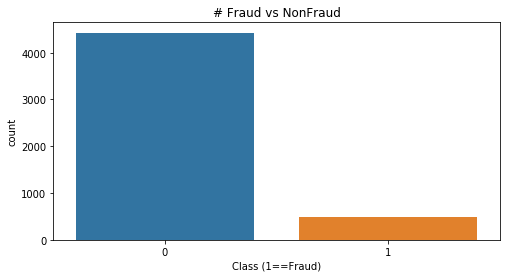

In [7]:
f, ax = plt.subplots(figsize=(8, 4))
sns.countplot(x='Class', data=balanced_credit_card)
_ = plt.title('# Fraud vs NonFraud')
_ = plt.xlabel('Class (1==Fraud)')

Split the data into train, test splits, future work could include undersampling methods to get better a more equal distribution in fraud/non-fraud cases

In [8]:
# Balanced dataset
train, test = train_test_split(balanced_credit_card, test_size=0.2, random_state=751)
x_train = train.drop('Class', axis=1)
y_train = train['Class']

x_test = test.drop('Class', axis=1)
y_test = test['Class']

In [9]:
# Run this cell to use the entire unbalanced dataset.
#train, test = train_test_split(balanced_credit_card, test_size=0.3, random_state=751)
#x_train = train.drop('Class', axis=1)
#y_train = train['Class']

#x_test = test.drop('Class', axis=1)
#y_test = test['Class']

## Baseline Logistic Regrssion model
Below is a simple logisitc regression model that fits the training data, the goal of this project is to see if we can improve on this model through stacking

In [10]:
baseline_model = LogisticRegression()
baseline_model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
y_hat = baseline_model.predict(x_train)
y_hat_prob = baseline_model.predict_proba(x_train)[:,1]

y_test_hat = baseline_model.predict(x_test)
y_test_hat_prob = baseline_model.predict_proba(x_test)[:,1]

train_accuracy = accuracy_score(y_train, y_hat)*100
test_accuracy = accuracy_score(y_test, y_test_hat)*100

train_auc_roc = roc_auc_score(y_train, y_hat_prob)*100
test_auc_roc = roc_auc_score(y_test, y_test_hat_prob)*100

test_precision = precision_score(y_test, y_test_hat)*100
test_recall = recall_score(y_test, y_test_hat)*100

In [12]:
print()
print('Training accuracy: %.4f %%' % train_accuracy)
print('Training AUC: %.4f %%' % train_auc_roc)
print("                              ")
print("##############################")
print("                              ")
print('Testing accuracy: %.4f %%' % test_accuracy)
print('Testing AUC: %.4f %%' % test_auc_roc)
print('Testing precision score: %.4f %%' % test_precision)
print('Testing recall score: %.4f %%' % test_recall)


Training accuracy: 98.4756 %
Training AUC: 98.3753 %
                              
##############################
                              
Testing accuracy: 98.6789 %
Testing AUC: 98.3029 %
Testing precision score: 100.0000 %
Testing recall score: 88.6957 %


We see that the baseline logistic regression model only has a testing recall score of 88% This means, the model is making a false negative prediction 12% of the time, let's try to bump this number up through stacking.

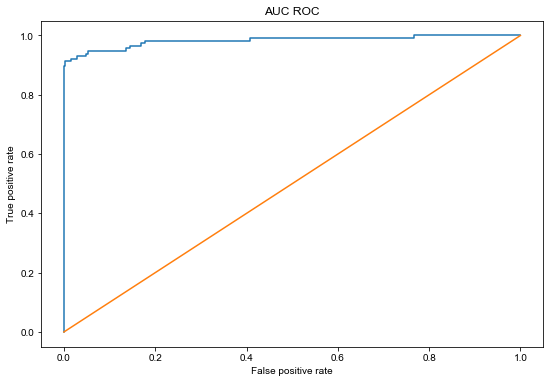

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_hat_prob, drop_intermediate=True)

f, ax = plt.subplots(figsize=(9, 6))
_ = plt.plot(fpr, tpr, [0,1], [0, 1])
_ = plt.title('AUC ROC')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
plt.style.use('seaborn')

In [14]:
def Stacking(model,train,y,test,n_fold):
    """ use cross-validation to generate the stacking features
    """  
    folds=KFold(n_splits=n_fold)
    
    test_pred=np.empty((test.shape[0],1),float)
    train_pred=np.empty((0,1),float)
    for train_indices,val_indices in folds.split(train,y.values):
        
        X_train,X_val=train.iloc[train_indices],train.iloc[val_indices]
        Y_train,Y_val=y.iloc[train_indices],y.iloc[val_indices]

        model.fit(X=X_train,y=Y_train)
        
        train_pred=np.append(train_pred,model.predict(X_val))
    # Finally, fit model on entire training set to make test predictions
    test_model = model.fit(train, y)
    test_pred = test_model.predict(test)
    return test_pred.reshape(-1,1),train_pred

def non_kfold_stack(model, train, y, test):
    """ Naively generate the stacking features, this will greatly reduce the run time, tradeoff for higher variance
        Doesn't really make a difference if using balanced subsample
    """
    model.fit(X=train, y=y)
    test_pred = model.predict(test).reshape(-1, 1)
    train_pred = model.predict(train)
    return pd.DataFrame(test_pred), pd.DataFrame(train_pred)

In [15]:
def summary_level1(train_pred, test_pred, y_train, y_test):
    """ Generate some statistics to evaluate our model
        Since our original dataset is highly imbalanced, measuring accuracy alone isn't enough
        Inputs:
                train_pred: model predictions of training set
                test_pred: model prediction of test set
                y_train: training y set fed into the model
                y_test: testing y to evaluate on
        Returns: test_pred and train_pred converted to pandas DataFrames
    """
    train_pred = pd.DataFrame(train_pred)
    test_pred = pd.DataFrame(test_pred)
    train_acc = accuracy_score(train_pred, y_train)
    test_acc = accuracy_score(test_pred, y_test)
    train_auc = roc_auc_score(train_pred, y_train)
    test_auc = roc_auc_score(test_pred, y_test)
    train_precision = precision_score(train_pred, y_train)
    test_precision = precision_score(test_pred, y_test)
    train_recall = recall_score(train_pred, y_train)
    test_recall = recall_score(test_pred, y_test)
        
    print("This model has Training accuracy: {:.4f} ; and testing accuracy {:.4f}".format(train_acc, test_acc))
    print("               Training auc: {:.4f} ; and testing auc {:.4f}".format(train_auc, test_auc))
    print("               Training precision: {:.4f} ; and testing precision {:.4f}".format(train_precision, test_precision))
    print("               Training recall: {:.4f} ; and testing recall {:.4f}".format(train_recall, test_recall))
    return test_pred, train_pred

# Stacking using Kfold cross validation

### level 1 model: Decision Trees

In [16]:
# Keep track of training times for meta-features
training_times = []

t0 =timeit.default_timer()
model1 = tree.DecisionTreeClassifier(max_depth=10)
test_pred1 ,train_pred1=Stacking(model=model1,n_fold=10, train=x_train,test=x_test,y=y_train)
t1 =timeit.default_timer()
training_times += [t1-t0]
print("It took {} seconds to train the Decision Tree  meta-features".format(t1-t0))
test_pred1 ,train_pred1=summary_level1(train_pred1, test_pred1,y_train, y_test)

It took 1.1121503329995903 seconds to train the Decision Tree  meta-features
This model has Training accuracy: 0.9776 ; and testing accuracy 0.9837
               Training auc: 0.9438 ; and testing auc 0.9745
               Training precision: 0.8594 ; and testing precision 0.8957
               Training recall: 0.9025 ; and testing recall 0.9626


### level 1 model: KNN

In [17]:
t0 =timeit.default_timer()
model2 = KNeighborsClassifier()
test_pred2 ,train_pred2=Stacking(model=model2,n_fold=10,train=x_train,test=x_test,y=y_train)
t1 =timeit.default_timer()
training_times += [t1-t0]
print("It took {} seconds to train the KNN meta-features".format(t1-t0))
test_pred2 ,train_pred2=summary_level1(train_pred2, test_pred2,y_train, y_test)

It took 0.9868660690008255 seconds to train the KNN meta-features
This model has Training accuracy: 0.9837 ; and testing accuracy 0.9837
               Training auc: 0.9841 ; and testing auc 0.9823
               Training precision: 0.8435 ; and testing precision 0.8783
               Training recall: 0.9845 ; and testing recall 0.9806


### level 1 model: SVC

In [18]:
t0 =timeit.default_timer()
model3 = SVC()
test_pred3 ,train_pred3=Stacking(model=model3,n_fold=10,train=x_train,test=x_test,y=y_train)
t1 =timeit.default_timer()
training_times += [t1-t0]
print("It took {} seconds to train the Support Vector Classifier meta-features".format(t1-t0))
test_pred3 ,train_pred3=summary_level1(train_pred3, test_pred3,y_train, y_test)

It took 0.9237685580010293 seconds to train the Support Vector Classifier meta-features
This model has Training accuracy: 0.9827 ; and testing accuracy 0.9848
               Training auc: 0.9863 ; and testing auc 0.9915
               Training precision: 0.8276 ; and testing precision 0.8696
               Training recall: 0.9905 ; and testing recall 1.0000


### level 1 model: RandomForest

In [19]:
t0 =timeit.default_timer()
model4 = RandomForestClassifier()
test_pred4 ,train_pred4=Stacking(model=model4,n_fold=10,train=x_train,test=x_test,y=y_train)
t1 =timeit.default_timer()
training_times += [t1-t0]
print("It took {} seconds to train the Random Forest meta-features".format(t1-t0))
test_pred4 ,train_pred4=summary_level1(train_pred4, test_pred4,y_train, y_test)

It took 15.328213108001364 seconds to train the Random Forest meta-features
This model has Training accuracy: 0.9850 ; and testing accuracy 0.9858
               Training auc: 0.9904 ; and testing auc 0.9921
               Training precision: 0.8462 ; and testing precision 0.8783
               Training recall: 0.9969 ; and testing recall 1.0000


### level 1 model: KMeans

In [20]:
t0 =timeit.default_timer()
model5 = KMeans(n_clusters=2, init="k-means++")
test_pred5 ,train_pred5=Stacking(model=model5,n_fold=10,train=x_train,test=x_test,y=y_train)
t1 =timeit.default_timer()
training_times += [t1-t0]
print("It took {} seconds to train the KMeans meta-features".format(t1-t0))
test_pred5 ,train_pred5=summary_level1(train_pred5, test_pred5,y_train, y_test)

It took 0.8332003699979396 seconds to train the KMeans meta-features
This model has Training accuracy: 0.7630 ; and testing accuracy 0.0610
               Training auc: 0.5482 ; and testing auc 0.0323
               Training precision: 0.3846 ; and testing precision 0.5217
               Training recall: 0.1714 ; and testing recall 0.0646


Kmeans does poorly here, seems like a problem with testing recall, however, incorporating Kmeans in the final aggregated model actually decreases performance.

### level 1 model: Naive Bayes

In [21]:
t0 =timeit.default_timer()
model6 = GaussianNB()
test_pred6 ,train_pred6=Stacking(model=model6,n_fold=10,train=x_train,test=x_test,y=y_train)
t1 =timeit.default_timer()
training_times += [t1-t0]
print("It took {} seconds to train the stacking features".format(t1-t0))
test_pred6 ,train_pred6=summary_level1(train_pred6, test_pred6,y_train, y_test)

It took 0.05208784700153046 seconds to train the stacking features
This model has Training accuracy: 0.9593 ; and testing accuracy 0.9685
               Training auc: 0.8736 ; and testing auc 0.9199
               Training precision: 0.8302 ; and testing precision 0.8783
               Training recall: 0.7653 ; and testing recall 0.8559


### level 1 model: LDA

In [22]:
t0 =timeit.default_timer()
model7 = LinearDiscriminantAnalysis()
test_pred7 ,train_pred7=Stacking(model=model7,n_fold=10,train=x_train,test=x_test,y=y_train)
t1 =timeit.default_timer()
training_times += [t1-t0]
print("It took {} seconds to train the stacking features".format(t1-t0))
test_pred7 ,train_pred7=summary_level1(train_pred7, test_pred7,y_train, y_test)

It took 0.2148840879999625 seconds to train the stacking features
This model has Training accuracy: 0.9756 ; and testing accuracy 0.9797
               Training auc: 0.9805 ; and testing auc 0.9888
               Training precision: 0.7560 ; and testing precision 0.8261
               Training recall: 0.9862 ; and testing recall 1.0000


### Level 1 model: logistic regression

In [55]:
t0 =timeit.default_timer()
model8 = LogisticRegression()
test_pred8 ,train_pred8=Stacking(model=model8,n_fold=4,train=x_train,test=x_test,y=y_train)
t1 =timeit.default_timer()
training_times += [t1-t0]
print("It took {} seconds to train the stacking features".format(t1-t0))
test_pred8 ,train_pred8=summary_level1(train_pred8, test_pred8,y_train, y_test)

It took 0.18346538599871565 seconds to train the stacking features
This model has Training accuracy: 0.9809 ; and testing accuracy 0.9878
               Training auc: 0.9716 ; and testing auc 0.9932
               Training precision: 0.8355 ; and testing precision 0.8957
               Training recall: 0.9604 ; and testing recall 1.0000


### level 1 model: Gradient Boosting Classifier

In [24]:
t0 =timeit.default_timer()
model9 = GradientBoostingClassifier()
test_pred9 ,train_pred9=Stacking(model=model9,n_fold=10,train=x_train,test=x_test,y=y_train)
t1 =timeit.default_timer()
training_times += [t1-t0]
print("It took {} seconds to train the stacking features".format(t1-t0))
test_pred9 ,train_pred9=summary_level1(train_pred9, test_pred9,y_train, y_test)

It took 30.334762125999987 seconds to train the stacking features
This model has Training accuracy: 0.9787 ; and testing accuracy 0.9817
               Training auc: 0.9565 ; and testing auc 0.9656
               Training precision: 0.8408 ; and testing precision 0.8957
               Training recall: 0.9296 ; and testing recall 0.9450


### level 1 model: AdaBoost Classifier

In [25]:
t0 =timeit.default_timer()
model10 = AdaBoostClassifier()
test_pred10 ,train_pred10=Stacking(model=model10,n_fold=10,train=x_train,test=x_test,y=y_train)
t1 =timeit.default_timer()
training_times += [t1-t0]
print("It took {} seconds to train the stacking features".format(t1-t0))
test_pred10 ,train_pred10=summary_level1(train_pred10, test_pred10,y_train, y_test)

It took 6.6591231810016325 seconds to train the stacking features
This model has Training accuracy: 0.9809 ; and testing accuracy 0.9817
               Training auc: 0.9631 ; and testing auc 0.9730
               Training precision: 0.8541 ; and testing precision 0.8783
               Training recall: 0.9415 ; and testing recall 0.9619


In [26]:
print("In total, it took {} seconds to generate all the meta-features through 10 fold cross validation".format(sum(training_times)))

In total, it took 56.97078863400384 seconds to generate all the meta-features through 10 fold cross validation


# Combine the stack features to be fed into one final aggregation model
### Try Aggregating with another logistic regression

In [27]:
df = pd.concat([train_pred1, train_pred2, train_pred3, train_pred4, train_pred6, train_pred7, train_pred8, train_pred9, train_pred10], axis=1)
df_test = pd.concat([test_pred1, test_pred2, test_pred3, test_pred4, test_pred6, test_pred7, test_pred8, test_pred9, test_pred10], axis=1)

model = LogisticRegression(random_state=751)

model.fit(df,y_train)
y_hat = model.predict(df)
y_test_hat = model.predict(df_test)
train_acc = accuracy_score(y_hat, y_train) * 100
test_acc = accuracy_score(y_test_hat, y_test) * 100

The below heatmap can give us a sense if our meta models are making the same prediction, if a line across a row is sold in color, then all models predict the same class for that instance.

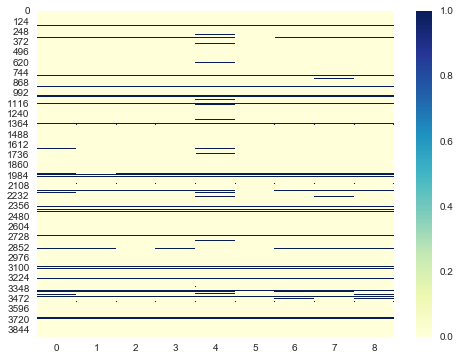

In [28]:
fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(df.values, cmap="YlGnBu")

In [29]:
y_hat = model.predict(df)
y_hat_prob = model.predict_proba(df)[:,1]

y_test_hat = model.predict(df_test)
y_test_hat_prob = model.predict_proba(df_test)[:,1]

train_accuracy = accuracy_score(y_train, y_hat)*100
test_accuracy = accuracy_score(y_test, y_test_hat)*100

train_auc_roc = roc_auc_score(y_train, y_hat_prob)*100
test_auc_roc = roc_auc_score(y_test, y_test_hat_prob)*100
test_precision = precision_score(y_test_hat, y_test)*100
test_recall = recall_score(y_test_hat, y_test)*100

train_precision = precision_score(y_hat, y_train)*100
train_recall = recall_score(y_train, y_hat)*100

In [31]:
print('Training accuracy: %.4f %%' % train_accuracy)
print('Training AUC: %.4f %%' % train_auc_roc)
print('Training precision: %.4f %%' % train_precision)
print('Training recall: %.4f %%' % train_recall)
print("                              ")
print("##############################")
print("                              ")
print('Testing accuracy: %.4f %%' % test_accuracy)
print('Testing AUC: %.4f %%' % test_auc_roc)
print('Testing precision: %.4f %%' % test_precision)
print('Testing recall: %.4f %%' % test_recall)

Training accuracy: 98.5518 %
Training AUC: 94.4524 %
Training precision: 85.4111 %
Training recall: 93.2496 %
                              
##############################
                              
Testing accuracy: 98.5772 %
Testing AUC: 95.5436 %
Testing precision: 86.0126 %
Testing recall: 92.4145 %


Our model accuracy is pretty similar to our previous basleine model, but we see a big increase in our testing recall.

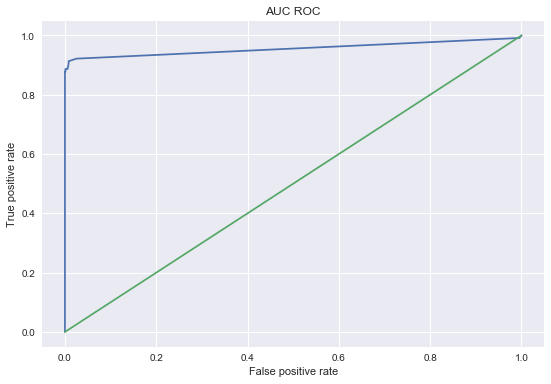

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_hat_prob, drop_intermediate=True)

f, ax = plt.subplots(figsize=(9, 6))
_ = plt.plot(fpr, tpr, [0,1], [0, 1])
_ = plt.title('AUC ROC')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
plt.style.use('seaborn')

# Stacking without kfold

(Originally implemented this since training on the entire original dataset takes forever, but under sampling took care of that)In the model above, the stacking meta-features were constructed using cross validation to make predictions for each fold in the training data. We will test if using the entire training set to generate meta-features instead decreases model performance.

In [33]:
t0=timeit.default_timer()
test_pred11 ,train_pred11=non_kfold_stack(model=model1, train=x_train,test=x_test,y=y_train)
test_pred22 ,train_pred22=non_kfold_stack(model=model2,train=x_train,test=x_test,y=y_train)
test_pred33 ,train_pred33=non_kfold_stack(model=model3,train=x_train,test=x_test,y=y_train)
test_pred44 ,train_pred44=non_kfold_stack(model=model4,train=x_train,test=x_test,y=y_train)
test_pred55 ,train_pred55=non_kfold_stack(model=model5,train=x_train,test=x_test,y=y_train)
test_pred66 ,train_pred66=non_kfold_stack(model=model6,train=x_train,test=x_test,y=y_train)
test_pred77 ,train_pred77=non_kfold_stack(model=model7,train=x_train,test=x_test,y=y_train)
test_pred88 ,train_pred88=non_kfold_stack(model=model8,train=x_train,test=x_test,y=y_train)
test_pred99 ,train_pred99=non_kfold_stack(model=model9,train=x_train,test=x_test,y=y_train)
test_pred1010 ,train_pred1010=non_kfold_stack(model=model10,train=x_train,test=x_test,y=y_train)


t1 = timeit.default_timer()
print("Without using Kfolds to generate the stacking features, it takes {} seconds to generate all \n meta-features".format(t1-t0))

kdf = pd.concat([train_pred11, train_pred22, train_pred33, train_pred44, train_pred55, train_pred66, train_pred77, train_pred88, train_pred99, train_pred1010], axis=1)
kdf_test = pd.concat([test_pred11, test_pred22, test_pred33, test_pred44, test_pred55, test_pred66, test_pred77, test_pred88, test_pred99, test_pred1010], axis=1)

# Stacking model
kmodel = LogisticRegression(random_state=751)

kmodel.fit(kdf,y_train)
ky_hat = kmodel.predict(kdf)
ky_hat_prob = kmodel.predict_proba(kdf)[:,1]
ky_test_hat = kmodel.predict(kdf_test)
ky_test_hat_prob = kmodel.predict_proba(kdf_test)[:,1]
ktrain_acc = accuracy_score(ky_hat, y_train) * 100
ktest_acc = accuracy_score(ky_test_hat, y_test) * 100
ktrain_auc_roc = roc_auc_score(y_train, ky_hat_prob)*100
ktest_auc_roc = roc_auc_score(y_test, ky_test_hat_prob)*100
ktest_recall = recall_score(ky_test_hat, y_test)*100
ktest_precision = precision_score(ky_test_hat, y_test)*100

print('Confusion matrix:\n', confusion_matrix(y_train, ky_hat))
print('Training accuracy: %.4f %%' % ktrain_acc)
print('Training AUC: %.4f %%' % ktrain_auc_roc)
print("                              ")
print("##############################")
print("                              ")
print('Confusion matrix:\n', confusion_matrix(y_test, ky_test_hat))
print('Testing accuracy: %.4f %%' % ktest_acc)
print('Testing AUC: %.4f %%' % ktest_auc_roc)
print('Testing precision: %.4f %%' % ktest_precision)
print('Testing recall: %.4f %%' % ktest_recall)

Without using Kfolds to generate the stacking features, it takes 7.123903894997056 seconds to generate all 
 meta-features
Confusion matrix:
 [[3559    0]
 [   0  377]]
Training accuracy: 100.0000 %
Training AUC: 100.0000 %
                              
##############################
                              
Confusion matrix:
 [[869   0]
 [ 13 102]]
Testing accuracy: 98.6789 %
Testing AUC: 96.3506 %
Testing precision: 88.6957 %
Testing recall: 100.0000 %


We see that performance is similar, but the baseline models are trained much faster now since don't need to use KFold to fit the stack, this difference is especially noticeable when we don't use the undersampled credit card data. However, without implementing Kfold to construct meta-feautures, we only make one incorrect prediction in the training, this is most likely due to overfitting, so we should do our Kfold.

## Aggregating Stacking Using Neutal Network
Finally, we combine the stacking meta-features, (with the original dataset), to be aggregated by a neural newtork
Try this for a nn for just the meta-features

In [34]:
df = pd.concat([train_pred1, train_pred2, train_pred3, train_pred4, train_pred6, train_pred7, train_pred8, train_pred9, train_pred10], axis=1)
df_test = pd.concat([test_pred1, test_pred2, test_pred3, test_pred4, test_pred6, test_pred7, test_pred8, test_pred9, test_pred10], axis=1)

In [35]:
modeln = Sequential()
modeln.add(Dense(30, input_shape=(9,), activation='relu')) # Hidden 1
modeln.add(Dropout(0.3))
modeln.add(Dense(15, activation='relu')) # Hidden 2
modeln.add(Dropout(0.3))
modeln.add(Dense(7, activation='relu')) # Hidden 2
modeln.add(Dropout(0.3))
modeln.add(Dense(1, activation='sigmoid')) # Output

modeln.compile(loss='binary_crossentropy', optimizer='Adam', metrics = ['acc'])

Using tanh instead of relu performs in precision

In [36]:
hist = modeln.fit(df, y_train, epochs=100, batch_size=100, validation_split=0.2)

Train on 3148 samples, validate on 788 samples
Epoch 1/100
3148/3148 [==============================] - 1s 220us/sample - loss: 0.6726 - acc: 0.9072 - val_loss: 0.6150 - val_acc: 0.8972
Epoch 2/100
3148/3148 [==============================] - 0s 22us/sample - loss: 0.5549 - acc: 0.9085 - val_loss: 0.4690 - val_acc: 0.8972
Epoch 3/100
3148/3148 [==============================] - 0s 22us/sample - loss: 0.4096 - acc: 0.9072 - val_loss: 0.3082 - val_acc: 0.8972
Epoch 4/100
3148/3148 [==============================] - 0s 26us/sample - loss: 0.2847 - acc: 0.9215 - val_loss: 0.1946 - val_acc: 0.8972
Epoch 5/100
3148/3148 [==============================] - 0s 26us/sample - loss: 0.2162 - acc: 0.9409 - val_loss: 0.1412 - val_acc: 0.9860
Epoch 6/100
3148/3148 [==============================] - 0s 25us/sample - loss: 0.1796 - acc: 0.9628 - val_loss: 0.1132 - val_acc: 0.9860
Epoch 7/100
3148/3148 [==============================] - 0s 24us/sample - loss: 0.1532 - acc: 0.9708 - val_loss: 0.0925 - va

3148/3148 [==============================] - 0s 16us/sample - loss: 0.0984 - acc: 0.9848 - val_loss: 0.0632 - val_acc: 0.9835
Epoch 60/100
3148/3148 [==============================] - 0s 22us/sample - loss: 0.0963 - acc: 0.9838 - val_loss: 0.0629 - val_acc: 0.9848
Epoch 61/100
3148/3148 [==============================] - 0s 17us/sample - loss: 0.0984 - acc: 0.9813 - val_loss: 0.0630 - val_acc: 0.9848
Epoch 62/100
3148/3148 [==============================] - 0s 16us/sample - loss: 0.0978 - acc: 0.9819 - val_loss: 0.0632 - val_acc: 0.9848
Epoch 63/100
3148/3148 [==============================] - 0s 16us/sample - loss: 0.0946 - acc: 0.9832 - val_loss: 0.0631 - val_acc: 0.9848
Epoch 64/100
3148/3148 [==============================] - 0s 18us/sample - loss: 0.0946 - acc: 0.9848 - val_loss: 0.0632 - val_acc: 0.9848
Epoch 65/100
3148/3148 [==============================] - 0s 21us/sample - loss: 0.0967 - acc: 0.9819 - val_loss: 0.0631 - val_acc: 0.9848
Epoch 66/100
3148/3148 [================

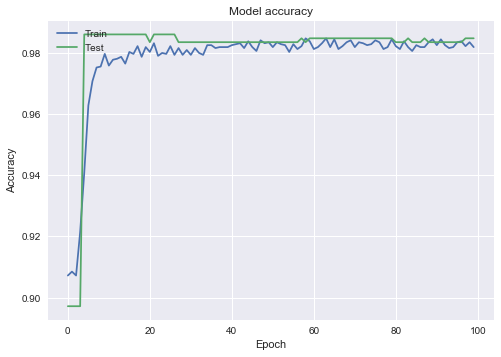

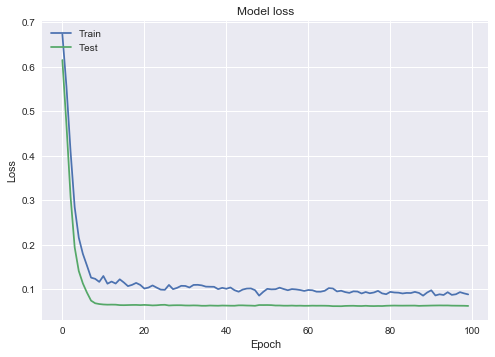

In [37]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [38]:
prob_kerasn = modeln.predict(df_test)
test_predn = [round(x[0]) for x in prob_kerasn]
train_predn = modeln.predict(df)
train_predn = [round(x[0]) for x in train_predn]

In [39]:
_,_=summary_level1(train_predn, test_predn, y_train, y_test)

This model has Training accuracy: 0.9860 ; and testing accuracy 0.9858
               Training auc: 0.9869 ; and testing auc 0.9878
               Training precision: 0.8647 ; and testing precision 0.8870
               Training recall: 0.9879 ; and testing recall 0.9903


## Finally, due to Neural Networks ability to efficiently handle high dimensional features, we try feeding the entire dataset with the meta learners 

In [40]:
nn_df = pd.concat([x_train.reset_index(drop=True), train_pred1.reset_index(drop=True),
                   train_pred2.reset_index(drop=True),train_pred3.reset_index(drop=True),
                   train_pred4.reset_index(drop=True),
                   train_pred6.reset_index(drop=True),train_pred7.reset_index(drop=True),
                   train_pred8.reset_index(drop=True),train_pred9.reset_index(drop=True),
                   train_pred10.reset_index(drop=True)], axis=1)

nn_df_test = pd.concat([x_test.reset_index(drop=True), test_pred1.reset_index(drop=True),
                   test_pred2.reset_index(drop=True),test_pred3.reset_index(drop=True),
                   test_pred4.reset_index(drop=True),
                   test_pred6.reset_index(drop=True),test_pred7.reset_index(drop=True),
                   test_pred8.reset_index(drop=True),test_pred9.reset_index(drop=True),
                   test_pred10.reset_index(drop=True)], axis=1)

In [41]:
nn_model = Sequential()
nn_model.add(Dense(30, input_shape=(40-1,), activation='relu')) # Hidden 1
nn_model.add(Dropout(0.3))
nn_model.add(Dense(15, activation='relu')) # Hidden 2
nn_model.add(Dropout(0.3))
nn_model.add(Dense(7, activation='relu')) # Hidden 2
nn_model.add(Dropout(0.3))
nn_model.add(Dense(1, activation='sigmoid')) # Output

nn_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics = ['acc'])

In [42]:
history = nn_model.fit(nn_df, y_train, epochs=100, batch_size=100, validation_split=0.3)

Train on 2755 samples, validate on 1181 samples
Epoch 1/100
2755/2755 [==============================] - 0s 176us/sample - loss: 0.6298 - acc: 0.6973 - val_loss: 0.5148 - val_acc: 0.9483
Epoch 2/100
2755/2755 [==============================] - 0s 18us/sample - loss: 0.5010 - acc: 0.8472 - val_loss: 0.3729 - val_acc: 0.9729
Epoch 3/100
2755/2755 [==============================] - 0s 18us/sample - loss: 0.4007 - acc: 0.9158 - val_loss: 0.2536 - val_acc: 0.9797
Epoch 4/100
2755/2755 [==============================] - 0s 18us/sample - loss: 0.3382 - acc: 0.9270 - val_loss: 0.1777 - val_acc: 0.9822
Epoch 5/100
2755/2755 [==============================] - 0s 18us/sample - loss: 0.2721 - acc: 0.9372 - val_loss: 0.1270 - val_acc: 0.9822
Epoch 6/100
2755/2755 [==============================] - 0s 18us/sample - loss: 0.2291 - acc: 0.9448 - val_loss: 0.0960 - val_acc: 0.9831
Epoch 7/100
2755/2755 [==============================] - 0s 18us/sample - loss: 0.2016 - acc: 0.9550 - val_loss: 0.0793 - v

2755/2755 [==============================] - 0s 18us/sample - loss: 0.0742 - acc: 0.9735 - val_loss: 0.0732 - val_acc: 0.9873
Epoch 60/100
2755/2755 [==============================] - 0s 18us/sample - loss: 0.0530 - acc: 0.9800 - val_loss: 0.0767 - val_acc: 0.9873
Epoch 61/100
2755/2755 [==============================] - 0s 18us/sample - loss: 0.0560 - acc: 0.9797 - val_loss: 0.0782 - val_acc: 0.9873
Epoch 62/100
2755/2755 [==============================] - 0s 18us/sample - loss: 0.0655 - acc: 0.9797 - val_loss: 0.0795 - val_acc: 0.9873
Epoch 63/100
2755/2755 [==============================] - 0s 18us/sample - loss: 0.0572 - acc: 0.9771 - val_loss: 0.0794 - val_acc: 0.9873
Epoch 64/100
2755/2755 [==============================] - 0s 18us/sample - loss: 0.0713 - acc: 0.9771 - val_loss: 0.0772 - val_acc: 0.9873
Epoch 65/100
2755/2755 [==============================] - 0s 17us/sample - loss: 0.0594 - acc: 0.9779 - val_loss: 0.0764 - val_acc: 0.9873
Epoch 66/100
2755/2755 [================

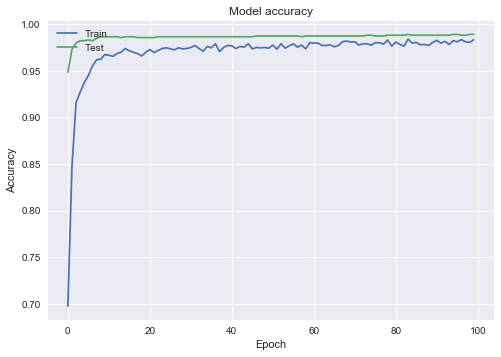

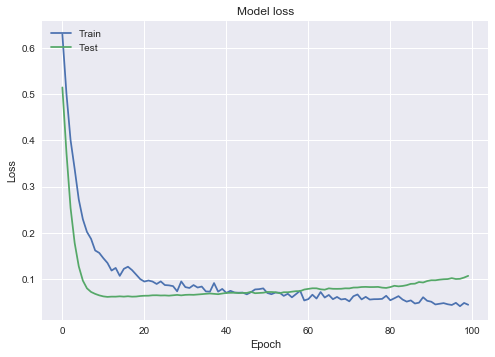

In [43]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [44]:
nn_test_pred = nn_model.predict(nn_df_test)
nn_test_pred = [round(x[0]) for x in nn_test_pred]

In [45]:
nn_train_pred = nn_model.predict(nn_df)
nn_train_pred = [round(x[0]) for x in nn_train_pred]

In [46]:
_,_=summary_level1(nn_train_pred, nn_test_pred, y_train, y_test)

This model has Training accuracy: 0.9916 ; and testing accuracy 0.9837
               Training auc: 0.9941 ; and testing auc 0.9745
               Training precision: 0.9151 ; and testing precision 0.8957
               Training recall: 0.9971 ; and testing recall 0.9626


In [47]:
nn_probs = nn_model.predict_proba(nn_df_test)

In [50]:
nn_df_test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,scaled_time,0,0,0,0,0,0,0,0,0
0,-0.756516,1.068593,1.532464,-0.193738,0.018853,-0.268830,0.461129,0.244064,-0.409166,0.139339,...,-0.078772,0,0,0,0,0,0,0,0,0
1,-2.025992,-1.252391,1.539821,0.101042,2.159934,-1.966541,-0.734649,0.305664,-0.066600,-0.777599,...,-0.086444,0,0,0,0,0,0,0,0,0
2,0.686957,-1.580332,-0.790755,-0.684467,1.030443,3.980299,-0.835597,0.976344,1.040306,-0.531021,...,-0.377530,0,0,0,0,0,0,0,0,0
3,2.309621,-1.490625,-1.145140,-1.714157,-0.967642,-0.076987,-1.268925,-0.052911,-0.971137,1.558277,...,0.821932,0,0,0,0,0,0,0,0,0
4,-0.059452,-3.579822,0.048555,-0.448273,-2.618167,-0.488163,-0.310095,-0.401702,-0.323326,0.696463,...,-0.933575,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,1.273789,-0.731878,0.255890,0.018355,-1.009519,-0.419561,-0.478711,-0.057190,-0.326566,0.618452,...,-0.107062,0,0,0,0,0,0,0,0,0
980,2.075849,-0.893296,-1.346985,-0.949922,-0.337627,-0.447143,-0.391778,-0.132986,-0.657363,0.875986,...,0.948237,0,0,0,0,0,0,0,0,0
981,-0.425656,0.918895,1.778858,0.175564,0.012725,-0.564843,0.734891,-0.105602,-0.307543,-0.695530,...,-0.471411,0,0,0,0,0,0,0,0,0
982,-4.198735,0.194121,-3.917586,3.920748,-1.875486,-2.118933,-3.614445,1.687884,-2.189871,-4.684233,...,-0.145267,1,1,1,1,1,1,1,1,1


In [48]:
roc_auc_score(y_test, nn_probs)

0.9867313753940061

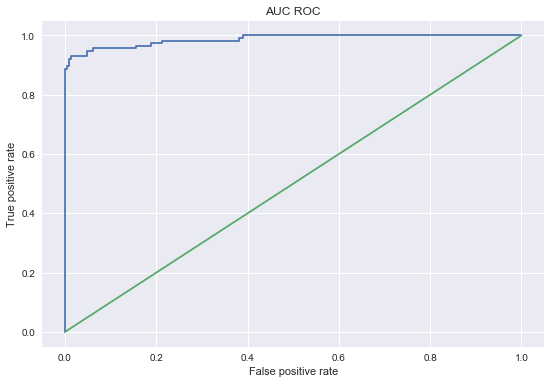

In [49]:
fpr, tpr, thresholds = roc_curve(y_test, nn_probs, drop_intermediate=True)

f, ax = plt.subplots(figsize=(9, 6))
_ = plt.plot(fpr, tpr, [0,1], [0, 1])
_ = plt.title('AUC ROC')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
plt.style.use('seaborn')

In [ ]:
nn_model.predict()